### Import and Load Modules, Features from the Dataset
#### Import Necessary Modules

In [9]:
#######skimage for Image Transformations
from skimage import img_as_float
from skimage import img_as_ubyte
from skimage import exposure
from skimage import filters
from skimage import color
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
import cv2

######## Matplotlib for Displaying Plots
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt


######## Random and Math and Numpy for Mathematical Operations
from random import randint
from random import uniform
import math
from numpy import sqrt
import numpy as np
from numpy import linalg
from numpy import dot


#####Pickle for Caching, Storing and Retrieving Data
import pickle

###### Import Shuffling function from SKLEARN
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

####### Pandas For Data Visualization, TQDM for Progress Bar
import pandas as pd
from tqdm import trange
from IPython.display import display, HTML
%matplotlib inline

print("Modules Imported")

Modules Imported


#### Load the Pickle File 

In [10]:
training_file = 'train.pickle'
validation_file='valid.pickle'
testing_file = 'test.pickle'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
C_train =train['coords']
S_train =train['sizes']

X_valid, y_valid = valid['features'], valid['labels']
C_valid=valid['coords']
S_valid=valid['sizes']

X_test, y_test = test['features'], test['labels']
C_test=test['coords']
S_test=test['sizes']

# Set Flags to make sure data is handled the right way 
is_normalized=False
is_dataAugmented = False
is_sorted=False
is_PCA=False
is_extended=False

print("Data and Modules loaded")

Data and Modules loaded


---

## Step 1: Functions for Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Summarizing the Spread and Characteristics of the dataset using Pandas
1. There are datsets that can be flippable and their meaning wouldnt essentially change.
+ There are signs which when flipped causes a change in their meaning. 
+ They are Summarized in a Pandas Data Frame.

<img src="files/DataVisualization.png">

#### DataSet Sort Function

<a id='Dataset Visualization Function'></a>
#### Dataset Visualization Function

In [11]:
def visualize_dataset(X_input,y_input, nr, nc):
    
    # Sort Images based on labels to batch the labels according to uniform size
    sorter = np.argsort(y_input)
    #Sort Dataset
    X_input=X_input[sorter]
    n_classes, counts=np.unique(y_input, return_counts=True)
    
    
    # TODO: Number of training examples
    n_train = len(X_input)
    # TODO: What's the shape of an traffic sign image?
    image_shape = X_input[0].shape
    df=pd.read_csv("signnames.csv")
  
    #### Populating the Data Frame 
    df['Counts']=counts
    # Random Check to verify if the sorting of data is consistent.
    randval=randint(0,len(X_input)-1)
    rowindex=y_input[randval]
    condition = df['ClassId'] == rowindex
    y_name=df[condition]
    

    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    df_sfh=np.empty(len(n_classes),dtype=object)
    for i in range(len(df_sfh)):
        if i in self_flippable_horizontally:
            df_sfh[i]="yes"
        else:
            df_sfh[i]="no"
    df['Horizontally Flippable']=df_sfh

    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    df_sfv=np.empty(len(n_classes),dtype=object)
    for i in range(len(df_sfv)):
        if i in self_flippable_vertically:
            df_sfv[i]="yes"
        else:
            df_sfv[i]="no"
    df['Vertically Flippable']=df_sfv

    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    df_sfb=np.empty(len(n_classes),dtype=object)
    for i in range(len(df_sfb)):
        if i in self_flippable_both:
            df_sfb[i]="yes"
        else:
            df_sfb[i]="no"
    df['Flippable Both Ways']=df_sfb


    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([[19, 20], [33, 34], [36, 37], [38, 39],[20, 19], [34, 33], [37, 36], [39, 38]])
    df_cf=np.empty(len(n_classes),dtype=object)
    for i in range(len(df_cf)):
        if i in cross_flippable:
            z=np.nonzero(cross_flippable[:,0] == i)
            df_cf[i]=df.ix[cross_flippable[z[0]][0][1],'SignName']
        else:
            df_cf[i]="no"
    df['CrossFlippable']=df_cf

    
    ############ Display Section #################
    print("Number of training examples =", n_train)
    print("Image data shape =", image_shape)
    print("Number of classes =", len(n_classes))
    print ("Image Datatype=",X_input.dtype) 
    plt.rcParams['figure.figsize'] = (16, 6)
    display(df)
    plt.grid()
    plt.xlabel("Class -ID")
    plt.ylabel("Number of Images")
    plt.title("Data Histogram")
    plt.bar(n_classes,counts)
    images_show(X_input,nr,nc,rand=True)
    

def images_show(X_input,nr,nc,rand):
    ############ Show randomly chosen 100 images 
    
    if (len(X_input.shape)==4 and (X_input.shape[3]!=3)):
        X_disp=np.reshape(X_input,(X_input.shape[0],X_input.shape[1],-1))
    else:
        X_disp=X_input
        

    if rand==True:
        randval1=randint(0,len(X_disp)-1)
    else:
        randval1=0
        
    randval2=randval1+(nr*nc)
    disp_im=X_disp[randval1:randval2]
    num_rows = nr
    num_cols = nc
    plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.1)
    ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]   
    for index,index_im in enumerate(disp_im):
        ax[index].imshow(index_im,cmap='gray')
        ax[index].axis('off')
    plt.show()

## Step 2:  Functions for Augmentation to supplement the dataset
The Augmentation algorithm is based on
Data augmentation batch iterator for feeding images into CNN.

###  Background Work
<img src="files/DataPreProcessingSteps.png">

**For Rotation , Translation & Shearing**
- **Rotate** all images in a given batch between -10 and 10 degrees.
- **Random Translations** between -10 and 10 pixels in all directions.
- **Random Zooms** between 1 and 1.3.
- **Random Shearing** between -25 and 25 degrees.
- randomly applies **Sobel Edge** detector to 1/4th of the images in each batch.
- **Randomly Inverts** 1/4 of the images in each batch.

> **Source:   https://github.com/vxy10/ImageAugmentation**  - Vivek Yadav on Traffic Sign Classification.

> **Source:   http://florianmuellerklein.github.io/cnn_streetview/** - Florian Mieller on Street View using CNNs

**Mirroring & Flipping Function**:
The function is used to augment the dataset with Zero Computational Effort
The process followed is 
- Identify classes that wouldn't change meaning when flipped
- Identify classes that can generate another class when flipped. 
- Make sure the labelling is done as per the change of meaning.  

> **Source:     http://navoshta.com/traffic-signs-classification **

### Functions for Image Normalization, Rotation , Augmentation , Flipping and Warping

In [12]:
########## Extend Dataset by Flipping and Rotation  ###########

def flip_extend(X, y): 
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([[19, 20], [33, 34], [36, 37], [38, 39],[20, 19], [34, 33], [37, 36], [39, 38]])
    num_classes, counts=np.unique(y, return_counts=True)
    
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(len(num_classes)):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        
        
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
            

        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)     
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
         
        
        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        
        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
            
            
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
    
    return (X_extended, y_extended)


def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def pca(X):
    
    #"""Principal Component Analysis
    #input: X, matrix with training data stored as flattened arrays in rows
    #return: projection matrix (with important dimensions first), variance
    #and mean."""
     # get dimensions
    X = np.asarray([grayscale(img) for img in X])
    n_samples=X.shape[0]
    height = X.shape[1]
    width = X.shape[2]
    
    ################ Global Centering ####################
    
    X= np.reshape(X,(X.shape[0],-1))
    mean_X = X.mean(axis=0)
    X = X - mean_X

  
    num_data,dim = X.shape
    if dim>num_data:
        # PCA - compact trick used
        M = dot(X,X.T) # covariance matrix
        e,EV = linalg.eigh(M) # eigenvalues and eigenvectors
        tmp = dot(X.T,EV).T # this is the compact trick
        V = tmp[::-1] # reverse since last eigenvectors are the ones we want
        S = sqrt(e[::-1]) # reverse since eigenvalues are in increasing order
        for i in range(V.shape[1]):
            V[:,i] /= S
            V_r = np.reshape(V,(-1,height,width))
    else:
        # PCA - SVD used
        U,S,V = linalg.svd(X)
        V = V[:num_data] # only makes sense to return the first num_data
        V_r = np.reshape(V,(-1,height,width))
    # return the projection matrix, the variance and the mean
    
    ###### Make sure the Mean Centered Image is Reshaped ##########
    mean_X_r=np.reshape(mean_X,(height,width))
    ######## The Modes are also reshaped but in the If Loop itself 
    
    return V_r,S,mean_X_r


####### Image Normalizer for exposure based histogram equalization ####### 
def image_center_normalize(X):
    
    n_samples=X.shape[0]
    n_h=X.shape[1]
    n_w=X.shape[2]
    
    print("Normalizing:")
    #Convert to grayscale, e.g. single Y channel
    X = np.asarray([grayscale(img) for img in X])
    X_f=np.reshape(X,(n_samples,-1))
    X_c=X_f-X_f.mean(axis=0)
    X_c/=X_f.std(axis=0)
    X_c-=X_f.mean(axis=1).reshape(n_samples,-1)
    X_c/=X_f.std(axis=1).reshape(n_samples,-1)
    X_c = (X_c / 255.).astype(np.float32)
    return np.reshape(X_c,(n_samples,n_h,n_w,1))
      
    
    
########### Image Rotate Function ################ 
def img_rotate(X, intensity):
    for i in range(X.shape[0]):
        delta = 30. * intensity # scale using augmentation intensity
        X[i] = rotate(X[i], uniform(-delta, delta), mode = 'edge')
    return X  


##################### For Affine , Shar, Scale and Rotation, Projective Transforms #######
def apply_projection_transform(X, intensity):
    image_size = X.shape[1]
    d = image_size * 0.3 * intensity
    for i in range(X.shape[0]):
        tl_top = uniform(-d, d)     # Top left corner, top margin
        tl_left = uniform(-d, d)    # Top left corner, left margin
        bl_bottom = uniform(-d, d)  # Bottom left corner, bottom margin
        bl_left = uniform(-d, d)    # Bottom left corner, left margin
        tr_top = uniform(-d, d)     # Top right corner, top margin
        tr_right =uniform(-d, d)   # Top right corner, right margin
        br_bottom =uniform(-d, d)  # Bottom right corner, bottom margin
        br_right = uniform(-d, d)   # Bottom right corner, right margin

        transform = ProjectiveTransform()
        transform.estimate(np.array((
                (tl_left, tl_top),
                (bl_left, image_size - bl_bottom),
                (image_size - br_right, image_size - br_bottom),
                (image_size - tr_right, tr_top)
            )), np.array((
                (0, 0),
                (0, image_size),
                (image_size, image_size),
                (image_size, 0)
            )))
        X[i] = warp(X[i], transform, output_shape=(image_size, image_size), order = 3, mode = 'edge')
        
    return X

In [13]:
def batch_iterator(X, Y, sample_size, intensity_factor):
    n_classes, counts=np.unique(Y, return_counts=True)
    offset=0
    for i in range(len(n_classes)):
        BATCH_SIZE=counts[i]-1
        # Augmentation factor is currently scaled based on 
        # number of samples required to match the class with max samples.
        aug_fac=(math.ceil(sample_size/BATCH_SIZE))-1
        batch_X, batch_Y = X[offset:offset+BATCH_SIZE], Y[offset:offset+BATCH_SIZE]
        # Use the batch iterator from previously
        # defined function to create Datasets
        print("Augmentation for Class:%s X:%s times,"% (i,aug_fac))
        if(aug_fac>0):
            for j in trange(aug_fac):
                X_aug,Y_aug=Augment_Images(batch_X,batch_Y, intensity_factor)
                X=np.concatenate((X,X_aug),axis=0)
                Y=np.concatenate((Y,Y_aug),axis=0)
        offset+=BATCH_SIZE+1     
    return X,Y

def Augment_Images(X,Y,intensity_factor):
    
    # Intensity defines the rate at which the Images are transformed
    # Rotate, Shear and Scale all images
    
    X= img_rotate(X, intensity_factor)
    X= apply_projection_transform(X, intensity_factor)
    
    # use sobel edge detector filter on one quarter of the images
    indices_sobel = np.random.choice(X.shape[0],int(X.shape[0]/6), replace = False)
    for k in indices_sobel:
        temp_img = X[k]
        X[k] = filters.sobel(temp_img)

           
    #Invert one quarter of the Images     
    indices_invert = np.random.choice(X.shape[0],int(X.shape[0]/6), replace = False)
    for l in indices_invert:
            img = X[l]
            X[l] = np.absolute(img - np.amax(img))
            
    return X,Y

#### Actual Execution & Calling Functions 

Number of training examples = 34799
Image data shape = (32, 32, 3)
Number of classes = 43
Image Datatype= uint8


,ClassId,SignName,Counts,Horizontally Flippable,Vertically Flippable,Flippable Both Ways,CrossFlippable
0,0,Speed limit (20km/h),180,no,no,no,no
1,1,Speed limit (30km/h),1980,no,yes,no,no
2,2,Speed limit (50km/h),2010,no,no,no,no
3,3,Speed limit (60km/h),1260,no,no,no,no
4,4,Speed limit (70km/h),1770,no,no,no,no
5,5,Speed limit (80km/h),1650,no,yes,no,no
6,6,End of speed limit (80km/h),360,no,no,no,no
7,7,Speed limit (100km/h),1290,no,no,no,no
8,8,Speed limit (120km/h),1260,no,no,no,no
9,9,No passing,1320,no,no,no,no


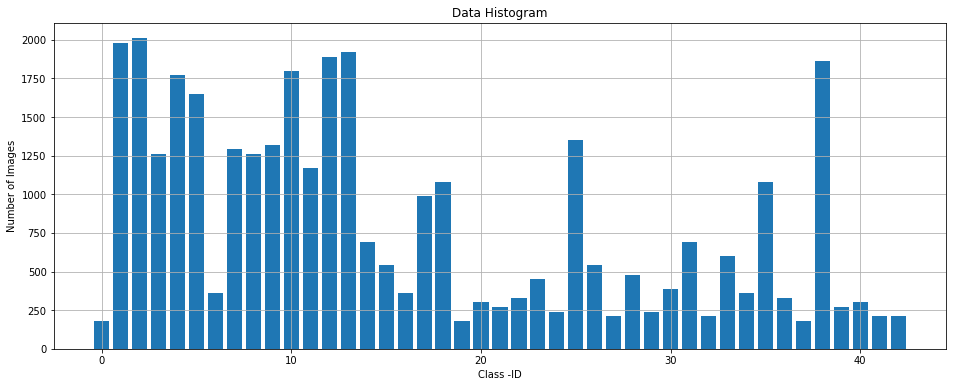

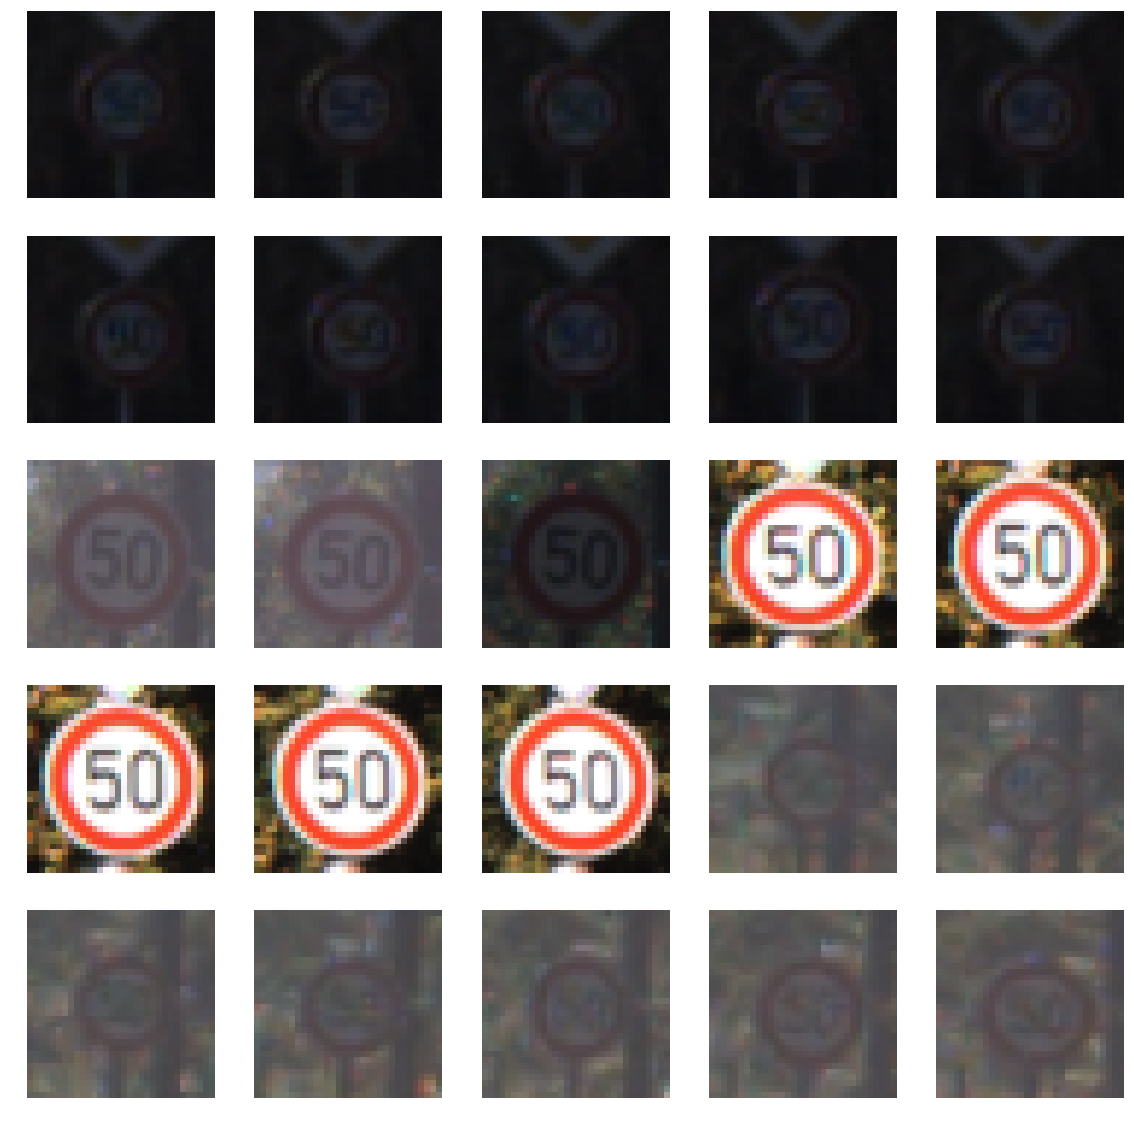

In [6]:
# Visualize Dataset
visualize_dataset(X_train,y_train, 5, 5)

#### Apply PCA and Normalize Data

In [ ]:
V,S,Mean=pca(X_train[180:1979])
print(V.shape)
pca_sorter=np.argsort(S)
V=V[pca_sorter]
images_show(V[1000:1024],4,5,rand=False)

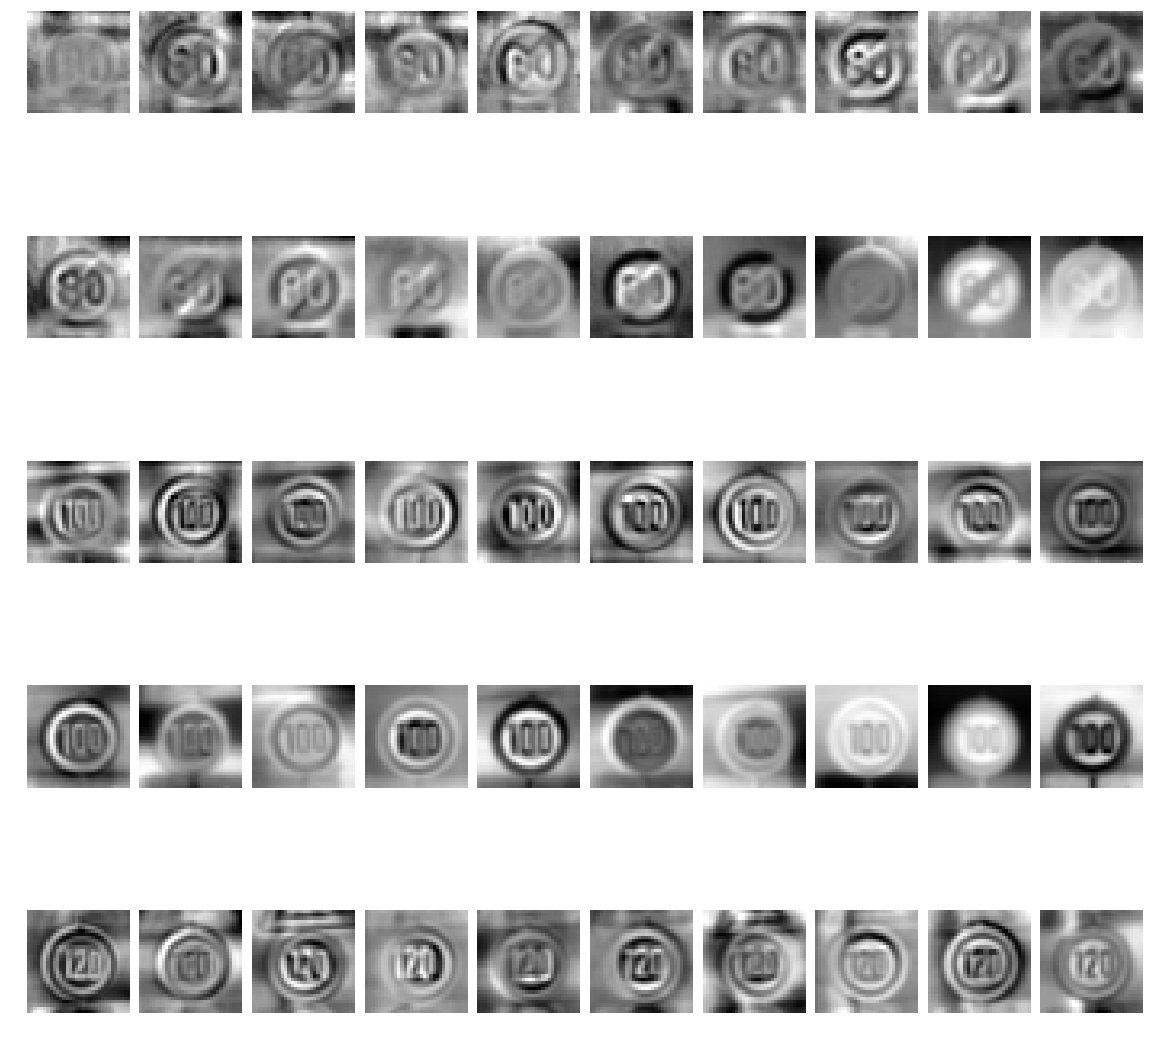

In [24]:
########## Sort Data ##############
if not is_sorted:
    sorter = np.argsort(y_train)
    #Sort Dataset
    y_train=y_train[sorter]
    X_train=X_train[sorter]
    is_sorted=True

    
########## PCA and store the data ##############
if not is_PCA:
    X_pca=np.asarray([grayscale(im).reshape(32,-1) for im in X_train[0:5]])
    y_pca=y_train[0:5]
    n_classes, counts=np.unique(y_train, return_counts=True)
    offset=0
    for i in range(len(n_classes)):
        BATCH_SIZE= counts[i]-1
        print("Classes:",n_classes[i])
        print("offset:",offset)
        print("Batch Size:",BATCH_SIZE)
        batch_X= X_train[offset:offset+BATCH_SIZE]
        V,S,Mean=pca(batch_X)
        pca_sorter=np.argsort(S)
        V=V[pca_sorter]
        if(BATCH_SIZE>1024):
            X_pca=np.concatenate((X_pca,V[1004:1024]),axis=0)
            y_pca=np.concatenate((y_pca,y_train[offset:offset+20]))
        else:
            X_pca=np.concatenate((X_pca,V[BATCH_SIZE-20:BATCH_SIZE]),axis=0)
            y_pca=np.concatenate((y_pca,y_train[offset:offset+20]))    
        offset+=BATCH_SIZE+1
    X_pca=np.reshape(X_pca,(X_pca.shape[0],X_pca.shape[1],X_pca.shape[2],-1))
    images_show(X_pca,5,10, rand=True)
    is_PCA=True
    
######## Normalize Dataset and Center it #########
if not is_normalized:
    X_train= image_center_normalize(X_train)
    print("Training Dataset Normalized")
    X_valid=image_center_normalize(X_valid)
    print("Validation Dataset Normalized")
    X_test=image_center_normalize(X_test)
    print("Test Dataset Normalized")
    is_normalized=True


######## Visualize Dataset post Extension using Flipping
if not is_extended:
    X_train,y_train=flip_extend(X_train, y_train)
    print("Dataset Extended")
    visualize_dataset(X_train,y_train,10,10)
    is_extended=True

### Augmentation Process
- Revisualization
- Re- Plotting the dataset post augmentation

Augmentation process ongoing
Augmentation for Class:0 X:11 times,


100%|██████████████████████████████████████████| 11/11 [00:04<00:00,  2.93it/s]


Augmentation for Class:1 X:0 times,
Augmentation for Class:2 X:0 times,
Augmentation for Class:3 X:1 times,


100%|████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Augmentation for Class:4 X:1 times,


100%|████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Augmentation for Class:5 X:0 times,
Augmentation for Class:6 X:5 times,


100%|████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


Augmentation for Class:7 X:1 times,


100%|████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Augmentation for Class:8 X:1 times,


100%|████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


Augmentation for Class:9 X:1 times,


100%|████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


Augmentation for Class:10 X:1 times,


100%|████████████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]


Augmentation for Class:11 X:0 times,
Augmentation for Class:12 X:0 times,
Augmentation for Class:13 X:0 times,
Augmentation for Class:14 X:2 times,


100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


Augmentation for Class:15 X:0 times,
Augmentation for Class:16 X:5 times,


100%|████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


Augmentation for Class:17 X:0 times,
Augmentation for Class:18 X:0 times,
Augmentation for Class:19 X:4 times,


100%|████████████████████████████████████████████| 4/4 [00:02<00:00,  1.31it/s]


Augmentation for Class:20 X:4 times,


100%|████████████████████████████████████████████| 4/4 [00:02<00:00,  1.57it/s]


Augmentation for Class:21 X:7 times,


100%|████████████████████████████████████████████| 7/7 [00:02<00:00,  2.39it/s]


Augmentation for Class:22 X:3 times,


100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s]


Augmentation for Class:23 X:4 times,


100%|████████████████████████████████████████████| 4/4 [00:02<00:00,  1.58it/s]


Augmentation for Class:24 X:8 times,


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.43it/s]


Augmentation for Class:25 X:1 times,


100%|████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


Augmentation for Class:26 X:1 times,


100%|████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Augmentation for Class:27 X:9 times,


100%|████████████████████████████████████████████| 9/9 [00:03<00:00,  2.49it/s]


Augmentation for Class:28 X:4 times,


100%|████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


Augmentation for Class:29 X:8 times,


100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.41it/s]


Augmentation for Class:30 X:2 times,


100%|████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


Augmentation for Class:31 X:2 times,


100%|████████████████████████████████████████████| 2/2 [00:01<00:00,  1.11it/s]


Augmentation for Class:32 X:4 times,


100%|████████████████████████████████████████████| 4/4 [00:02<00:00,  1.54it/s]


Augmentation for Class:33 X:2 times,


100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/it]


Augmentation for Class:34 X:2 times,


100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/it]


Augmentation for Class:35 X:0 times,
Augmentation for Class:36 X:3 times,


100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.37it/s]


Augmentation for Class:37 X:3 times,


100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.44it/s]


Augmentation for Class:38 X:0 times,
Augmentation for Class:39 X:0 times,
Augmentation for Class:40 X:3 times,


100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s]


Augmentation for Class:41 X:9 times,


100%|████████████████████████████████████████████| 9/9 [00:03<00:00,  2.32it/s]


Augmentation for Class:42 X:9 times,


100%|████████████████████████████████████████████| 9/9 [00:03<00:00,  2.39it/s]


shuffle successsful


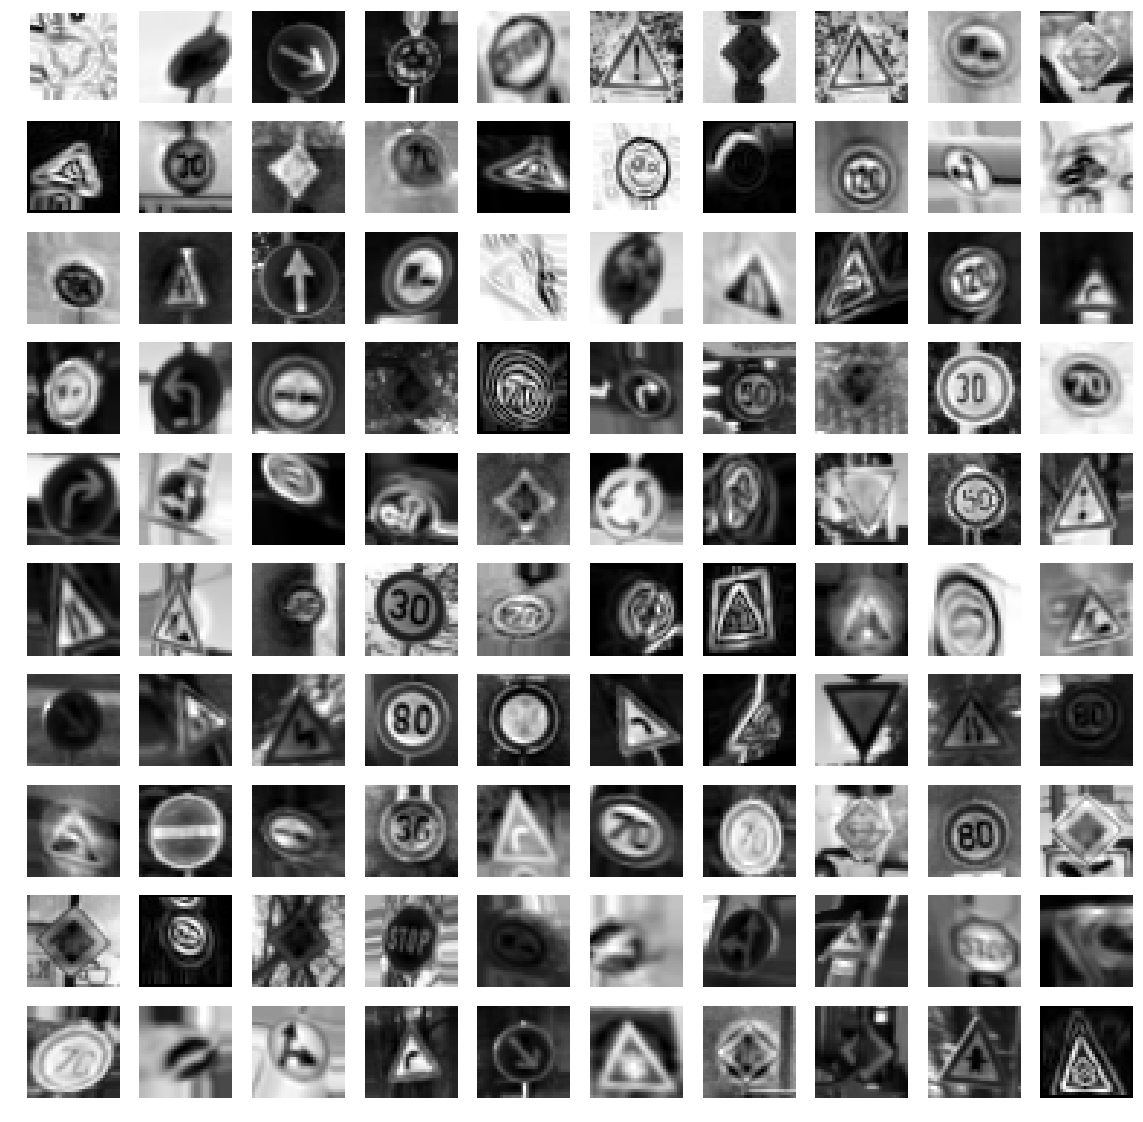

New Training Dataset Size: 112100


In [21]:
############# Augment Data based on Classes 
if not is_dataAugmented:
    offset=0
    print("Augmentation process ongoing")
    n_samples,height,width,depth=X_train.shape
    X_train,y_train=batch_iterator(np.reshape(X_train,(n_samples,height,-1)), y_train, sample_size=2000, intensity_factor=0.5)
    is_dataAugmented = True
    
# Randomly Display 100 images in a given class to
# see the output of augmentation 
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid=shuffle(X_valid,y_valid)
print("shuffle successsful")

############### Check 100 Augmented Dataset Samples 
randval1=randint(0,len(X_train)-1)
randval2=randval1+100
disp_im,disp_lab=X_train[randval1:randval2],y_train[randval1:randval2]
num_rows = 10
num_cols = 10
plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.1)
ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]   
for index,index_im in enumerate(disp_im):
    ax[index].imshow(index_im.squeeze(),cmap='gray')
    ax[index].axis('off')
plt.show()



# Make sure the augmented data set is a number divisible by 10 for easy batching 
mod=len(X_train)%100
trunc=100-mod
index_range=np.arange(0,trunc,1)
for j in index_range:
    rand_index=randint(0,len(X_train)-1)
    temp1=np.expand_dims(X_train[rand_index],axis=0)
    temp2=np.expand_dims(y_train[rand_index],axis=0)
    X_train=np.append(X_train,temp1,axis=0)
    y_train=np.append(y_train,temp2,axis=0)

X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2],-1))    
#### Flag to store flag if the augmented data of features are cached.
is_augcached=False
print("New Training Dataset Size:",len(X_train))

#### Merge the Training and Validation Set and Reshuffle to maintain a healthy 20% Ratio

In [62]:
# visualize_dataset(X_train,y_train,5,5)

X_master=np.concatenate((X_train,X_valid),axis=0)
y_master=np.concatenate((y_train,y_valid),axis=0)

X_master=np.concatenate((X_master,X_pca),axis=0)
y_master=np.concatenate((y_master,y_pca),axis=0)


# Get randomized datasets for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_master,y_master,test_size=0.20,random_state=832289)
print("Dataset Reshuffled, Labels and Features Split and Randomized")

Dataset Reshuffled, Labels and Features Split and Randomized


## Completed Preprocessing and Ready for Model Training
### Run Cell Below to Validate the same
### This cell will also pickle the updated files

In [63]:
# Save the data for easy access
# assert is_features_normal, 'You skipped the step to normalize the features'
# assert is_dataAugmented, 'You skipped the step to Augment Dataset'
# assert is_validdataAugmented, 'You skipped augmenting Validation Dataset'

training_file = 'train_aug.pickle'
validation_file='valid_aug.pickle'
testing_file = 'test_aug.pickle'


if not is_augcached:
  
    try:
        with open(training_file, 'wb') as pfile:
            pickle.dump(
                {
                    'features': X_train,
                    'labels': y_train
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

    try:
        with open(validation_file, 'wb') as pfile:
            pickle.dump(
                {
                    'features': X_valid,
                    'labels': y_valid
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise


    try:
        with open(testing_file, 'wb') as pfile:
            pickle.dump(
                {
                    'features': X_test,
                    'labels': y_test
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
    is_augcached=True
        
print('Data cached in pickle file.')

Data cached in pickle file.


## Checkpoint - Once pre processing is done . You can load this file directly. 

In [26]:
####### Module to retrieve pickled data######
import pickle
from sklearn.utils import shuffle

########## Plotting Data ########
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from tqdm import trange


###### Visualizing DataFrame ########
import pandas as pd

####### Image Operations ###########
from skimage import img_as_ubyte
from skimage import img_as_float
import cv2

####### Mathematical & Array Operations #########
import numpy as np
import math
from random import randint


############ Tensor FLow for Neural Network Frameworks
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import apply_regularization
from tensorflow.contrib.layers import l1_regularizer
from tensorflow.contrib.layers import xavier_initializer

In [ ]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train_aug.pickle'
validation_file='valid_aug.pickle'
testing_file = 'test_aug.pickle'

is_data_loaded=False
if not is_data_loaded:

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_valid, y_valid = valid['features'], valid['labels']
    X_test, y_test = test['features'], test['labels']
    

    is_data_loaded=True


# Set Flags to make sure data is handled the right way 
is_features_normal = True
is_dataAugmented = True

print("Data and Modules loaded")

####  Before Proceeding Load all Helper Functions
<a href='#Dataset Visualization Function'>Helper Functions</a>

Number of training examples = 112100
Image data shape = (32, 32)
Number of classes = 43
Image Datatype= float32


,ClassId,SignName,Counts,Horizontally Flippable,Vertically Flippable,Flippable Both Ways,CrossFlippable
0,0,Speed limit (20km/h),2151,no,no,no,no
1,1,Speed limit (30km/h),3963,no,yes,no,no
2,2,Speed limit (50km/h),2011,no,no,no,no
3,3,Speed limit (60km/h),2523,no,no,no,no
4,4,Speed limit (70km/h),3540,no,no,no,no
5,5,Speed limit (80km/h),3304,no,yes,no,no
6,6,End of speed limit (80km/h),2157,no,no,no,no
7,7,Speed limit (100km/h),2581,no,no,no,no
8,8,Speed limit (120km/h),2520,no,no,no,no
9,9,No passing,2641,no,no,no,no


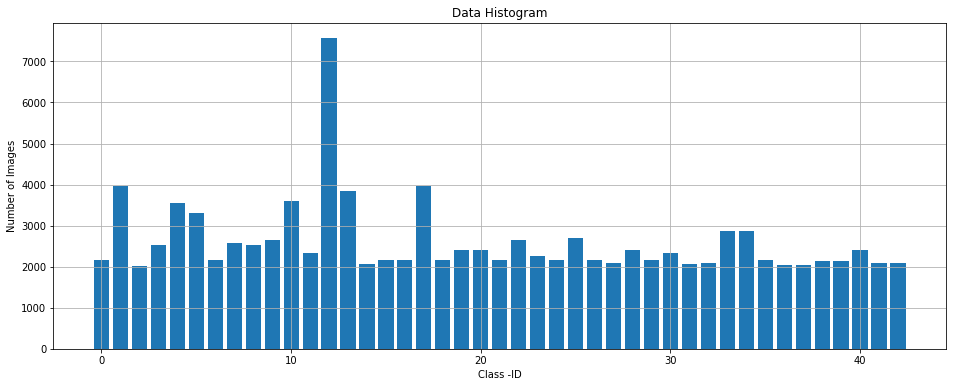

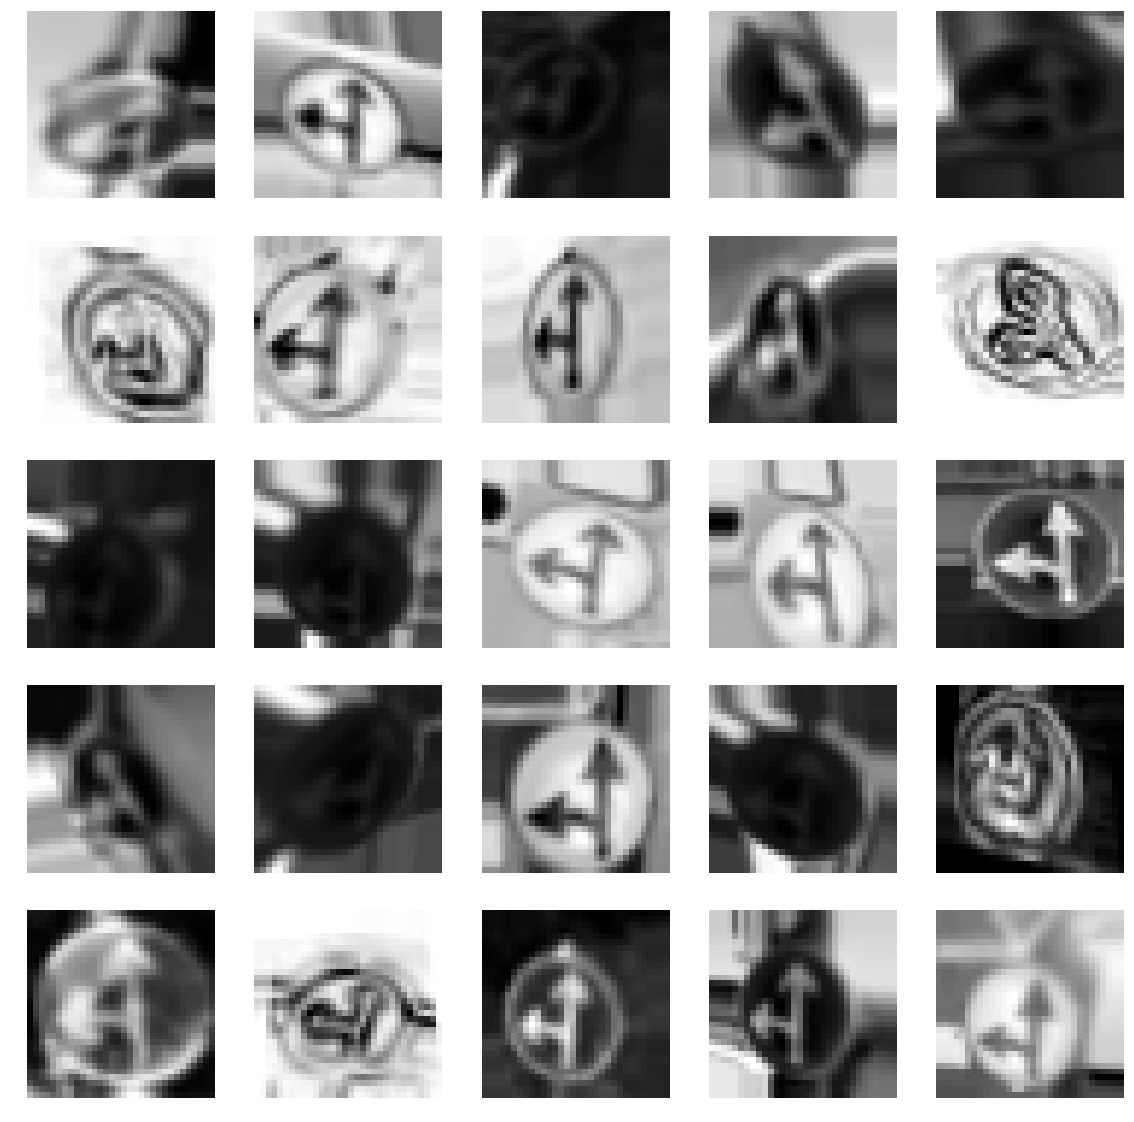

In [29]:
visualize_dataset(X_train,y_train,5,5)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Modified LeNet Architecture With FeedForward and FeedBack Loops and Spatial Transform Based Architecture


In [43]:
tf.reset_default_graph()
########## Graph Inputs #########################

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
num_classes=43
keep_prob=tf.placeholder(tf.float32,None)
reg_fac=tf.placeholder(tf.float32,None)
rate=tf.placeholder(tf.float32,None)

### Basic Elements of the VGG Network
- **Param Relu** For solving Dead Linear Rectifier issue during training
- **Convolution Layer** With Parametric Relay Activation - Weights and Biases Initialization - Xavier Scheme
- **Fully Connected Layer** With Fully Connected Dense Layers - Weights and Biases Initialization - Xavier Scheme
- ** Pooling Layer** Max Pool 2D Operation

In [44]:
def parametric_relu(input_,name):
    alpha = tf.get_variable(name=name+'_alpha', shape=input_.get_shape()[-1],initializer=tf.random_uniform_initializer(minval=0.1, maxval=0.3), dtype=tf.float32)
    pos = tf.nn.relu(input_)
    neg = alpha * (input_ - abs(input_)) * 0.5
    return pos + neg

def conv(input_, name, k1, k2, n_o, s1=1, s2=1):
    n_i = input_.get_shape()[-1].value
    with tf.variable_scope(name):
        weights = tf.get_variable('weights', [k1, k2, n_i, n_o], tf.float32, xavier_initializer())
        biases = tf.get_variable("bias", [n_o], tf.float32, tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input_, weights, (1, s1, s2, 1), padding='SAME')
        activation = parametric_relu(tf.nn.bias_add(conv, biases),"activation")
        return activation

def fc(input_, name, n_o):
    n_i = input_.get_shape()[-1].value
    with tf.variable_scope(name):
        weights = tf.get_variable('weights', [n_i, n_o], tf.float32, xavier_initializer())
        biases = tf.get_variable("bias", [n_o], tf.float32, tf.constant_initializer(0.0))
        logits = tf.nn.bias_add(tf.matmul(input_, weights), biases)
        return parametric_relu(logits, "activation")

def pool(input_, name, k1, k2, s1=2, s2=2):
    return tf.nn.max_pool(input_,ksize=[1, k1, k2, 1],strides=[1, s1, s2, 1],padding='VALID',name=name)                             

### VGG Layer
- 2 Back to Back **Convolutions** of same Kernel Size and Strides and Padding as specified by the user
- 1 **Pooling** Layer.

In [45]:
def VGG_Layer(input_, name_, conv_size, pool_size, n_o):
    
    n_i = input_.get_shape()[-1].value
    c_k1=conv_size
    c_k2=conv_size 
    p_k1=pool_size
    p_k2=pool_size
    
    ############## VGG Building Block ###############################
    ############## 2 - Conv , 1- Pool ###############################
    vgg = conv(input_, name=name_+"conv1_1", k1=c_k1, k2=c_k2, n_o=n_o)
    vgg = conv(vgg, name=name_+"conv1_2", k1=c_k1, k2=c_k2, n_o=n_o)
    vgg = pool(vgg, name=name_+"pool1", k1=p_k1, k2=p_k2)
    
    
    return vgg

### Model definition
#### Number of Layers:
- *3* **VGG** Layers
    - First VGG Layer extracts 64 Feature Maps
    - Second VGG Layer extracts 128 Feature Maps
    - Third VGG Layer extracts 256 Feature Maps
- *2* **FC** Layers
    - Fully Connected Layers 512 Hidden Units
    - To 43 Units dependent on the number of classes

#### Reason for Choosing Architecture:
- LeNet acrhitecture provides 96.5% test accuracy 
- To get the extra 2% accuracy on the model.

In [46]:
def run_model(input_, num_classes, keep_prob):
    
    ################################# VGG- Layer - 1 ##############################################
    vgg1=VGG_Layer(input_, "vgg1", conv_size= 3, pool_size= 2, n_o=64)
    vgg1 = tf.nn.dropout(vgg1, keep_prob)
    
    ################################# VGG- Layer - 2 ##############################################
    vgg2=VGG_Layer(vgg1, "vgg2", conv_size= 3, pool_size= 2, n_o=128)
    vgg2 = tf.nn.dropout(vgg2, keep_prob)
    
    ################################# VGG- Layer - 3 ##############################################
    vgg3=VGG_Layer(vgg2, "vgg3", conv_size= 3, pool_size= 2, n_o=256)
    vgg3 = tf.nn.dropout(vgg3, keep_prob)
    

    ################## Fully Connected Layers for a Linear Classifier ###########################    
    #############################First Fully Connected Layer ##################################
    fc0=fc(flatten(vgg2),"fc0", 512)
    fc0 = tf.nn.dropout(fc0, keep_prob)
    ########################### Second fully Connected Layer ##################################
    fc1=fc(fc0,"fc1",num_classes)
    
    return fc1

### Model Building with Hyper_params

In [47]:
logits=run_model(x, num_classes, keep_prob)
one_hot_y = tf.one_hot(y, num_classes)

###For Top 5 Guesses 
prediction = tf.nn.softmax(logits)
top5_guesses= tf.nn.top_k(prediction, k=5, sorted=True)
########### Predicted Label and Actual Label using Argmax
y_pred= tf.argmax(logits, 1)
y_act=tf.argmax(one_hot_y, 1)

######### Cross Entropy and Loss for Training ##########
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)

################### L2 Regularization ######################
L2=0
for i in tf.get_collection('variables'):
    L2+= tf.nn.l2_loss(i)

loss_operation = tf.reduce_mean(cross_entropy) + L2*reg_fac

########## Accuracy Calculation 
correct_prediction = tf.equal(y_pred,y_act)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

########### Training Step ################
Train_Step = tf.train.AdamOptimizer(rate).minimize(loss_operation)


In [48]:
def evaluate(X_data,y_data,prob_rate,reg_factor,l_rate,batch_size):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        bx, by = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        inputs_ = {x: bx, y: by, keep_prob:prob_rate, reg_fac:reg_factor, rate:l_rate}
        accuracy = sess.run(accuracy_operation, feed_dict=inputs_)
        total_accuracy += (accuracy * len(bx))
    return total_accuracy / num_examples

    
class StatLogger:
    """
    file writer to record various statistics
    """

    def __init__(self, fpath):
        import os
        import os.path as pth

        self.fpath = fpath
        fdir = pth.split(fpath)[0]
        if len(fdir) > 0 and not pth.exists(fdir):
            os.makedirs(fdir)


    def report(self, step, **kwargs):
        import json
        with open(self.fpath, "a") as fh:
            data = {
                "step": step
            }
            data.update(kwargs)
            fh.write(json.dumps(data) + "\n")
            


### Model Hyper Parameter Definition
- The Hyper Parameters are chosen based on search over 5 epochs
#### Tuning Methodology

- Xavier Initialization
- **Early Stopping** - Restore Chkpt if the accuracy gains in validation don't meet requirements
- **Hyper Parameter** Search over 5 Epcochs for Initial Tuning Hyper Params for best choice of hyper params 
    - Batch Sizes-100,200,300,500
    - Learning rates- 1e-3,5e-4,4e-4,1e-4
    - Regularization factor 1e-5,1e-4, 5e-4
- **Learning rate annealing**,  **Batch size increment**, **Increase dropout rate**

In [51]:
BATCH_SIZE=200
EPOCHS=5
KEEP_RATE=1.0
REG_FACTOR=5e-4
RATE=5e-5
save_file="VGGNet"
Load_Model=False
chkpt = './'+ save_file
save_='./'+"VGGNet_test"

In [ ]:
init = tf.global_variables_initializer()
sess = tf.Session()

saver = tf.train.Saver()
log=StatLogger(chkpt)
with sess.as_default():
    sess.run(init)
    ##################  Start Model Training  #######################
    saver.restore(sess, chkpt)
    print("Training...")
    print()
    for i in range(EPOCHS):
        tr_acc=0
        val_acc=0
        ############ Training Operation ################
        X_train, y_train = shuffle(X_train, y_train)
        for offset in trange(0, len(X_train), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            inputs = {x: batch_x, y: batch_y, keep_prob:KEEP_RATE, reg_fac:REG_FACTOR, rate:RATE}
            sess.run(Train_Step, feed_dict=inputs)
            
        Training_Accuracy=evaluate(X_train,y_train,KEEP_RATE,REG_FACTOR,RATE,BATCH_SIZE)
        Validation_Accuracy=evaluate(X_valid,y_valid,1.0,REG_FACTOR,RATE,BATCH_SIZE)
        
        print("Epochs:",i)
        print("Training_Accuracy:", Training_Accuracy)
        print("Validation_Accuracy:", Validation_Accuracy)
        if not(i%5):
            saver.save(sess, save_)
            print("Intermediate Model Save")
              
# ####### Save Weights #####################
saver.save(sess, chkpt)    
print("Model saved")


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
saver=tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_)
    test_accuracy = evaluate(X_test, y_test, 1.0, 5e-5, 2e-4, 300)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

In [ ]:
import matplotlib.gridspec as gridspec
from skimage import exposure
from skimage import img_as_ubyte
from skimage import img_as_float
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def image_normalizer(X_data):
    image=cv2.imread(X_data, cv2.IMREAD_COLOR)
    img_output= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_output =exposure.equalize_adapthist(img_output)
#     img_output=cv2.resize(image,(32,32))
    return img_output

def show_Images(n_row,n_col,X):
    
    disp_im=X
    num_rows = n_row
    num_cols = n_col
    
    plt.figure(figsize=(7,7))
    gs = gridspec.GridSpec(num_rows, num_cols, wspace=1.0)
    ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
    for index,index_im in enumerate(disp_im):
        ax[index].imshow(index_im,cmap='gray')
        ax[index].axis('off')
    plt.show()
    
    
def visualize_predictions(images,image_names,top5_pred):
    df=pd.read_csv('./'+'signnames.csv')
    for i in range(len(images)):
        plt.figure(figsize = (5,1.5))
        gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])
        plt.subplot(gs[0])
        plt.imshow(images[i])
        plt.axis('off')
        plt.subplot(gs[1])
        plt.barh(6-np.arange(5),top5_pred[0][0], align='center')
        for i_label in range(5):
            plt.text(top5_pred[0][0][i_label]+0.1,6-i_label-.25, df['SignName'][top5_pred[1][i][i_label]])
        plt.axis('off');
        plt.text(0,6.95,image_names[i].split('.')[0])
        plt.show()    


In [ ]:
###### Load Model and Open 
def run_model(images,image_names):
    saver=tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        top5_pred = sess.run(top5_guesses, feed_dict={x:images,keep_prob: 1.0})
        print(top5_pred)
    visualize_predictions(images,image_names,top5_pred)

def test_classifier(img_path):
    randomtestdata = [image_normalizer(img_path+name) for name in os.listdir(img_path) if name.endswith('.png')]
    namenewdata = [name for name in os.listdir(img_path) if name.endswith('.png')]
    rndtestint = img_as_float(randomtestdata)
    show_Images(1,len(namenewdata),rndtestint)
    run_model(rndtestint,namenewdata)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

### Predict the Sign Type for Each Image

In [ ]:
### Define Path of Test Images
image_path ="./Test_images/"
test_classifier(image_path)

## Visualize the top 5 predictions
### The concept of Visualization is borrowed from Vivek Yadav - Who has intelligently used matplot lib to view the top 5 predictions

## Other Images that are not from the GTSRB 
### Similar but color difference based Images

In [ ]:
otherimage_path ="./OtherSigns/"
test_classifier(otherimage_path)

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

image_path='./Test_images/SpeedLimit80kmph.png'
image=image_normalizer(image_path)


def outputFeatureMap(image_input, tf_activation, chkpt, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    with tf.Session() as sess:
        saver.restore(sess, chkpt)
        image_reshape=np.expand_dims(image_input,axis=0)
        activation = tf_activation.eval(session=sess,feed_dict={x : image_reshape})
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(30,25))
        for featuremap in range(featuremaps):
            plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            

In [ ]:
outputFeatureMap(image,vgg1,chkpt)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 